<a href="https://colab.research.google.com/github/chihina/rdf-interpolation-by-myself-python/blob/master/4_2_classifying_names_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tutorial 4-2: NLP From Scratch: Classifying Names with a Character-Level RNN**  
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#preparing-the-data

# Overview

In this tutorial, we will be building and training a basic character-level RNN to classify words.  



*   how to do preprocess data for NLP modeling “from scratch”.
*   A character-level RNN reads words as a series of characters.



# Prepare the data

## download dataset

In [1]:
! wget https://download.pytorch.org/tutorial/data.zip
! unzip data.zip
! ls

--2021-01-19 04:22:53--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.35.44, 99.86.35.58, 99.86.35.29, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.35.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  6.05MB/s    in 0.5s    

2021-01-19 04:22:54 (6.05 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.tx

## Check dataset

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# names examples of Italian
print(category_lines['Italian'][:5])

['data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. 

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Creating the Network
 

## Define RNN network

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

## letter test

In [5]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

## Line test


In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8131, -2.9386, -2.9029, -2.9207, -2.9167, -2.8303, -2.9187, -2.8660,
         -2.8236, -2.8076, -2.9211, -2.8838, -2.9206, -2.9123, -2.9297, -2.9352,
         -2.8398, -2.9662]], grad_fn=<LogSoftmaxBackward>)


# Training

## Preparing for Training
Define the helper function to change output into categories labels 

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 9)


Define the helper function to generate random samples

In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Siemon
category = Vietnamese / line = Pho
category = English / line = Rowley
category = French / line = Parris
category = French / line = Paget
category = Czech / line = Kusak
category = Dutch / line = Romeijnders
category = Czech / line = Kazmier
category = Dutch / line = Buggenum
category = Polish / line = Gorski


## Training the Network

In [9]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.1039 Adamczyk / Polish ✓
10000 10% (0m 13s) 1.9051 Vargas / Portuguese ✓
15000 15% (0m 20s) 0.8035 Yeon / Korean ✓
20000 20% (0m 27s) 0.4548 Yeon / Korean ✓
25000 25% (0m 34s) 2.5105 Gray / Vietnamese ✗ (Scottish)
30000 30% (0m 40s) 1.4354 Thibault / French ✓
35000 35% (0m 47s) 0.8111 To / Vietnamese ✓
40000 40% (0m 54s) 2.2808 Albuquerque / French ✗ (Portuguese)
45000 45% (1m 1s) 1.7691 Movchun / Irish ✗ (Russian)
50000 50% (1m 8s) 2.8648 Kavanagh / Japanese ✗ (Irish)
55000 55% (1m 14s) 0.3520 Tcharnetsky / Russian ✓
60000 60% (1m 21s) 1.1250 Apeldoorn / Dutch ✓
65000 65% (1m 28s) 0.6376 Winograd / Polish ✓
70000 70% (1m 35s) 2.7149 Han / Chinese ✗ (Korean)
75000 75% (1m 41s) 1.4940 Bishara / Japanese ✗ (Arabic)
80000 80% (1m 48s) 1.7557 Sarto / Portuguese ✗ (Italian)
85000 85% (1m 55s) 2.7556 Vaisfeld / English ✗ (Russian)
90000 90% (2m 2s) 1.3692 Schultheiss / Greek ✗ (German)
95000 95% (2m 9s) 0.8038 Smith / Scottish ✓
100000 100% (2m 15s) 1.8693 Mcintosh / German

## Plotting the Results

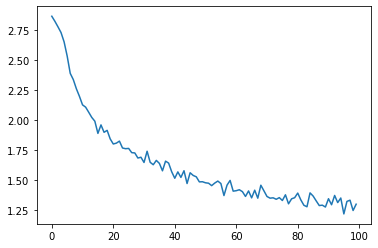

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

## Confusion matrix

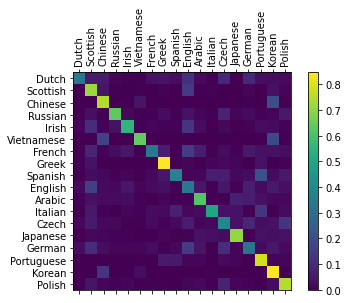

In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Running on User Input

In [13]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.67) Czech
(-0.93) Russian
(-2.76) English

> Jackson
(-0.41) Scottish
(-1.57) English
(-2.99) Czech

> Satoshi
(-1.04) Japanese
(-1.27) Arabic
(-1.58) Polish
